In [1]:
import pandas as pd

# Load the datasets
data_last = pd.read_csv('data_last.csv')
data_mkt_cap = pd.read_csv('data_mkt_cap.csv')
data_sector = pd.read_csv('data_sector.csv')
data_volume = pd.read_csv('data_volume.csv')

# Display the first few rows of each dataset to understand their structure
(data_last.head(), data_mkt_cap.head(), data_sector.head(), data_volume.head())

(    ticker        date    last
 0  1332 JT  2017-08-16  562.12
 1  1332 JT  2017-08-17  560.36
 2  1332 JT  2017-08-18  553.32
 3  1332 JT  2017-08-21  544.53
 4  1332 JT  2017-08-22  535.73,
     ticker        date    mkt_cap
 0  1332 JT  2017-08-16  199642.95
 1  1332 JT  2017-08-17  199018.09
 2  1332 JT  2017-08-18  196518.64
 3  1332 JT  2017-08-21  193394.34
 4  1332 JT  2017-08-22  190270.04,
     ticker             bics_sector
 0  1332 JT  Consumer, Non-cyclical
 1  1333 JT  Consumer, Non-cyclical
 2  1334 JT  Consumer, Non-cyclical
 3  1605 JT                  Energy
 4  1721 JT              Industrial,
     ticker        date     volume
 0  1332 JT  2017-08-16  1641300.0
 1  1332 JT  2017-08-17  1247700.0
 2  1332 JT  2017-08-18  1505800.0
 3  1332 JT  2017-08-21  2046200.0
 4  1332 JT  2017-08-22  2409300.0)

In [2]:
# Merge the datasets on 'ticker' and 'date' to create a comprehensive dataframe
# Start by merging price and volume data, then market cap, and finally sector information
df_merged = pd.merge(data_last, data_volume, on=['ticker', 'date'], how='inner')
df_merged = pd.merge(df_merged, data_mkt_cap, on=['ticker', 'date'], how='inner')
df_merged = pd.merge(df_merged, data_sector, on='ticker', how='inner')

# Display the first few rows of the merged dataframe to ensure correctness
df_merged.head(20)


,ticker,date,last,volume,mkt_cap,bics_sector
0,1332 JT,2017-08-16,562.12,1641300.0,199642.95,"Consumer, Non-cyclical"
1,1332 JT,2017-08-17,560.36,1247700.0,199018.09,"Consumer, Non-cyclical"
2,1332 JT,2017-08-18,553.32,1505800.0,196518.64,"Consumer, Non-cyclical"
3,1332 JT,2017-08-21,544.53,2046200.0,193394.34,"Consumer, Non-cyclical"
4,1332 JT,2017-08-22,535.73,2409300.0,190270.04,"Consumer, Non-cyclical"


In [22]:
df_merged.head(5)

,ticker,date,last,volume,mkt_cap,bics_sector
0,1332 JT,2017-08-16,562.12,1641300.0,199642.95,"Consumer, Non-cyclical"
1,1332 JT,2017-08-17,560.36,1247700.0,199018.09,"Consumer, Non-cyclical"
2,1332 JT,2017-08-18,553.32,1505800.0,196518.64,"Consumer, Non-cyclical"
3,1332 JT,2017-08-21,544.53,2046200.0,193394.34,"Consumer, Non-cyclical"
4,1332 JT,2017-08-22,535.73,2409300.0,190270.04,"Consumer, Non-cyclical"


In [3]:
# Identify unique sectors
unique_sectors = df_merged['bics_sector'].unique()

# Display the unique sectors
unique_sectors

array(['Consumer, Non-cyclical', 'Energy', 'Industrial',
       'Consumer, Cyclical', 'Communications', 'Technology', 'Financial',
       'Basic Materials', 'Utilities'], dtype=object)

Group by Sector: Use the "bics_sector" column to group stocks by their sector. Pair trading within the same sector reduces exposure to sector-wide risk factors, as companies in the same sector often experience similar economic impacts.

In [9]:
# save the mearged data to a csv file
df_merged.to_csv('df_merged.csv', index=False)


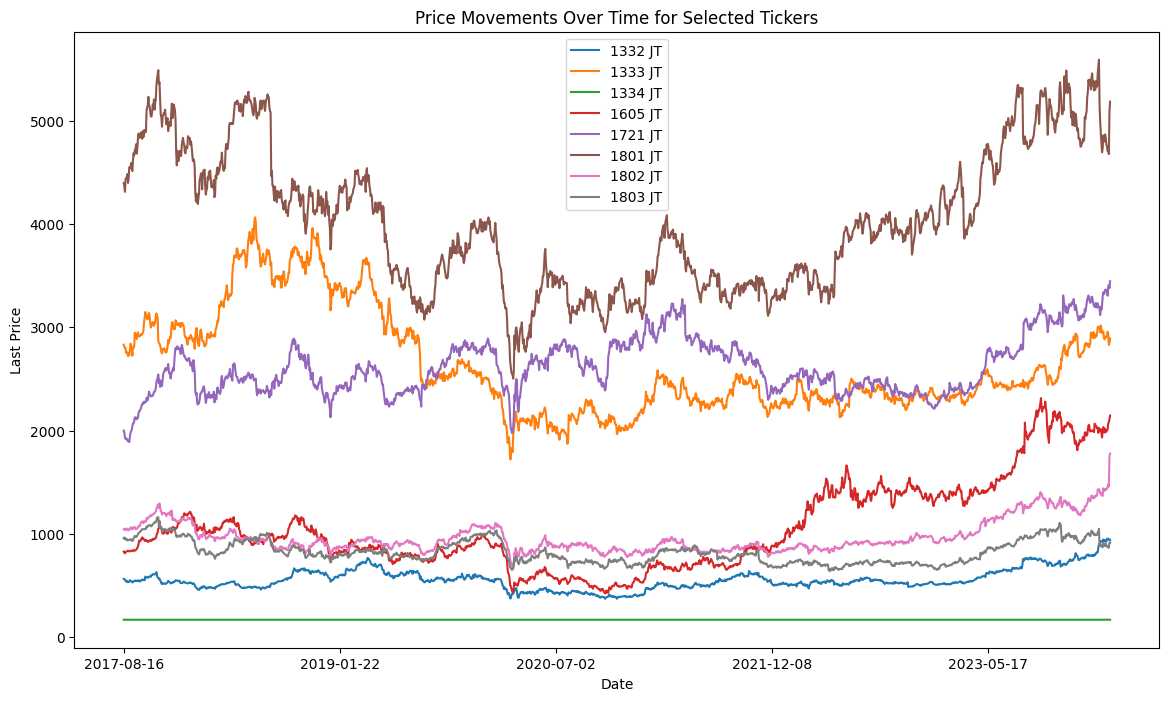

In [31]:
import matplotlib.pyplot as plt

# Select a subset of tickers to plot
sample_tickers = df_merged['ticker'].unique()[:8]  # Select the first 5 unique tickers for simplicity

plt.figure(figsize=(14, 8))

for ticker in sample_tickers:
    subset = df_merged[df_merged['ticker'] == ticker]
    plt.plot(subset['date'], subset['last'], label=ticker)

plt.title('Price Movements Over Time for Selected Tickers')
plt.xlabel('Date')
plt.ylabel('Last Price')
plt.legend()
# use the year as unit of the x ticks
plt.xticks(subset['date'][::350])
plt.show()

In [36]:
# it seems that the pair trading will be one useful strategy to use in this case
# let us use the price as the column, and the ticker as the index
df_pivot = df_merged.pivot(index='date', columns='ticker', values='last')
df_ret=df_pivot.pct_change().T.drop(['2017-08-16'], axis=1)
df_ret.head()
df_ret.shape

(263, 1598)

In [198]:
df_pivot.T.to_csv('data_trade.csv', index=True)

In [40]:
# it seems that we have some null values in the return dataframe
# check any null values
df_ret.isnull().sum()
# check which tickers have null values
df_ret[df_ret.isnull().any(axis=1)]
# delete the tickers with null values
df_ret = df_ret.dropna()
df_ret.shape

(259, 1598)

In [157]:
from sklearn.decomposition import PCA
N_PRIN_COMPONENTS = 35
pca1 = PCA(n_components = N_PRIN_COMPONENTS)
pca1.fit(df_ret.T)
pca1.components_.T.shape

(259, 35)

In [158]:
reduced_price = pd.DataFrame(data = pca1.components_.T, index = df_ret.index)
reduced_price = reduced_price.add_prefix("P")
reduced_price.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34
ticker,,,,,,,,,,,,,,,,,,,,,
1332 JT,5.013912e-02,4.885194e-02,6.721017e-02,-1.406789e-02,-1.691937e-02,2.564387e-02,-1.682890e-02,1.706300e-02,4.371215e-02,6.060204e-02,...,1.286133e-02,4.269217e-02,3.369832e-02,-2.244520e-02,8.786416e-03,-5.208625e-02,4.137553e-03,-8.472604e-04,8.181466e-02,3.932424e-02
1333 JT,4.137071e-02,5.460519e-02,6.808250e-02,-2.189421e-02,-2.554788e-02,-1.100871e-03,-3.416595e-02,1.822548e-02,6.322684e-02,4.473311e-02,...,-1.656040e-02,4.920510e-02,8.510581e-03,-2.600893e-02,-4.546625e-02,-1.853144e-04,2.349742e-02,1.323513e-02,6.047190e-02,-3.989679e-02
1334 JT,3.619855e-23,-4.143086e-19,5.291220e-18,-1.242880e-16,2.720135e-17,1.302190e-17,-5.083963e-17,3.505172e-18,9.251016e-17,-1.717793e-17,...,-4.287358e-17,7.142224e-17,2.851727e-17,1.159501e-17,3.308218e-17,1.936294e-17,4.295588e-17,-3.888726e-17,7.734480e-18,-8.682313e-17
1605 JT,7.055351e-02,5.977771e-02,-7.468832e-02,-8.265331e-02,-1.001781e-01,-6.767933e-02,1.409432e-01,8.194850e-02,-7.200465e-02,-7.308808e-02,...,-1.480469e-02,-5.442019e-02,-5.209272e-02,-6.666740e-02,2.595530e-02,-1.328992e-02,4.751514e-02,-5.827615e-02,2.942253e-02,6.737753e-02
1721 JT,4.617151e-02,-3.202192e-03,6.656736e-02,-4.620451e-02,-1.739497e-02,-5.676959e-02,-4.017509e-02,-1.262527e-02,6.224621e-02,-2.423145e-02,...,1.478796e-02,-2.919300e-03,3.248468e-02,7.623456e-03,4.162874e-03,-2.210633e-02,3.125627e-02,-4.324520e-03,1.538810e-03,5.597832e-02


In [159]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN

train_data = preprocessing.StandardScaler().fit_transform(reduced_price)
print(train_data.shape)

clf = DBSCAN(eps=1.8, min_samples = 3, n_jobs = 1)
clf.fit(train_data)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Clusters discovered: %d" % n_clusters_)


(259, 35)
Clusters discovered: 6


In [160]:
X= reduced_price
clustered = clf.labels_
clustered_series = pd.Series(index = X.index, data = clustered.flatten())
clustered_series_all = pd.Series(index = X.index, data = clustered.flatten())
clustered_series = clustered_series[clustered_series != 1]

In [161]:
cluster_size_limit = 100
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 5
Pairs to evaluate: 86


In [162]:
#plot multidimension to 2d
X_tsne = TSNE(learning_rate = 1000, perplexity = 25, random_state = 1337).fit_transform(X)

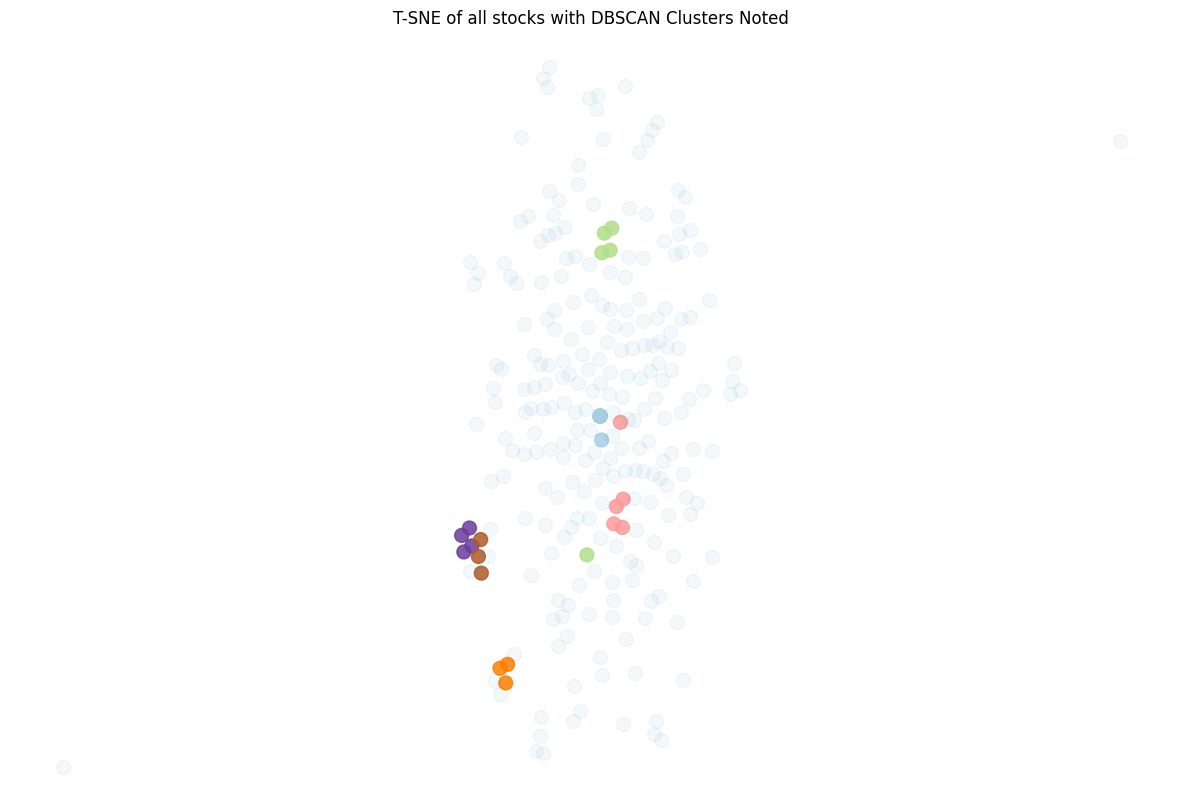

In [163]:
plt.figure(1, facecolor = 'white', figsize = (15, 10))
plt.clf()
plt.axis('off')

plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s = 100, alpha = 0.85, c = labels[labels!=-1], cmap = cm.Paired)
plt.scatter(X_tsne[(clustered_series_all==-1).values, 0], X_tsne[(clustered_series_all==-1).values, 1], s = 100, alpha = 0.05)
plt.title('T-SNE of all stocks with DBSCAN Clusters Noted')
plt.savefig('T-SNE_plot_for_stock_clusters.png')
plt.show()

In [164]:
counts = clustered_series.value_counts()
clusters_viz_list = list(counts[(counts < 500) & (counts > 1)].index)[::-1]
print(clusters_viz_list)

[5, 3, 4, 2, 0, -1]


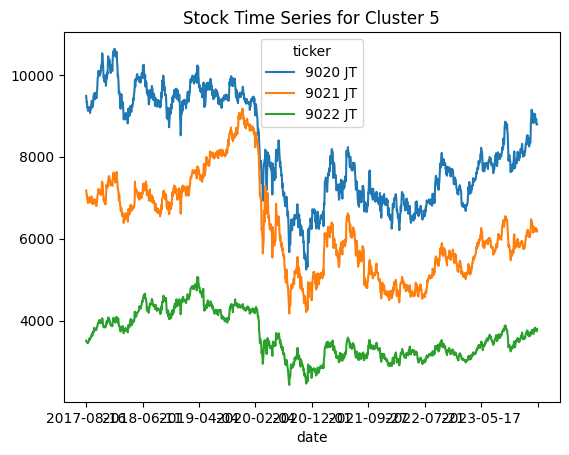

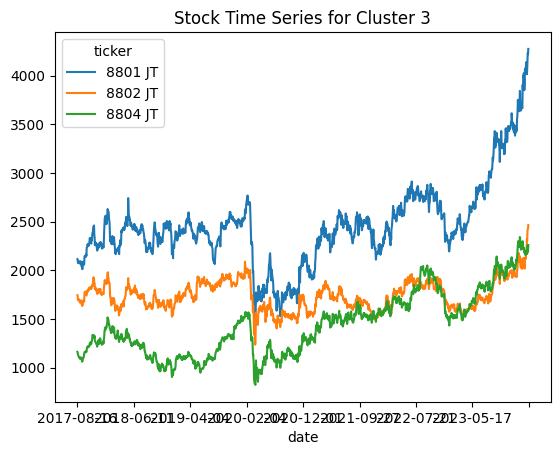

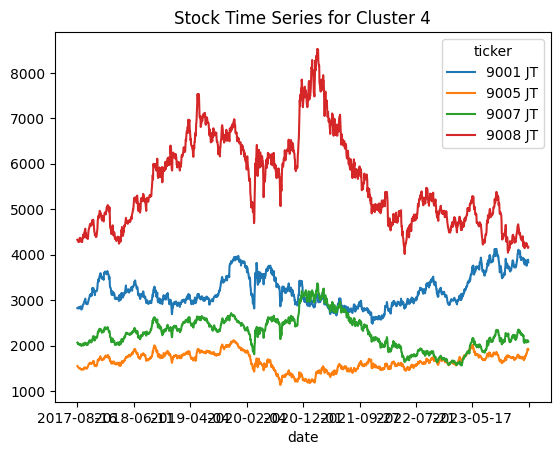

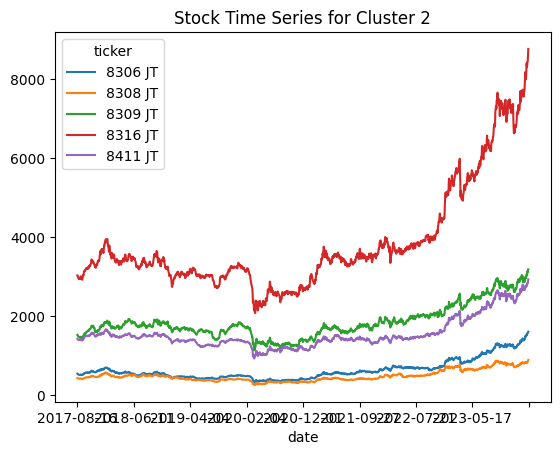

In [165]:
stock_price= df_pivot.T
for c in clusters_viz_list:
    if c == -1 or c == 0:
        continue
    stocks = list(clustered_series[clustered_series==c].index)
    data = stock_price.loc[stocks,].T
    data.plot(title='Stock Time Series for Cluster %d' % c)
    plt.savefig('stock_price_clsuter_'+str(c)+'.png')
    plt.show()

In [154]:
data.index.min

<bound method Index.min of Index(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-21', '2017-08-22',
       '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-28', '2017-08-29',
       ...
       '2024-02-21', '2024-02-22', '2024-02-26', '2024-02-27', '2024-02-28',
       '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06'],
      dtype='object', name='date', length=1599)>

In [166]:
import heapq
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
def Cointegration(cluster, significance, start_day, end_day, Price):
    pair_coin = []
    p_value = []
    n = cluster.shape[0]
    keys = cluster.keys()
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = Price.loc[keys[i], start_day:end_day]
            asset_2 = Price.loc[keys[j], start_day:end_day]
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            if ADFtest[1] < significance:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
    return p_value, pair_coin

def PairSelection(clustered_series, significance, start_day, end_day, Price, E_selection = False):
    Opt_pairs = []   # to get best pair in cluster i
    
    if E_selection == True: # select one pair from each cluster
        for i in clusters_viz_list:
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day, Price)
            if len(result[0]) > 0:
                if np.min(result[0]) < significance:
                    index = np.where(result[0] == np.min(result[0]))[0][0]
                    Opt_pairs.append([result[1][index][0], result[1][index][1]]) 
    else:
        p_value_contval = []
        pairs_contval = []
        for i in clusters_viz_list:
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day, Price)
            if len(result[0]) > 0:
                p_value_contval += result[0]
                pairs_contval += result[1]
        
        Opt_pair_index = heapq.nsmallest(20, range(len(p_value_contval)), key=p_value_contval.__getitem__)
        Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
    return Opt_pairs

In [187]:
# ingore the warning
import warnings
warnings.filterwarnings("ignore")
# find the optimal pairs
significance = 0.05
start_date = '2017-08-16'
end_date = "2024-03-06"

opt_pairs2 = PairSelection(clustered_series, significance, start_date, end_date, stock_price, E_selection = True)
print("Number of clusters: ",len(ticker_count_reduced))
print("Pairs with lowest p-value among all the clusters:")
opt_pairs2

Number of clusters:  5
Pairs with lowest p-value among all the clusters:


[['9020 JT', '9022 JT'], ['1334 JT', '5413 JT'], ['1721 JT', '2282 JT']]

we find there is an overlapping pair, which is ['9020 JT', '9022 JT'], we will do the pair trading for this stock

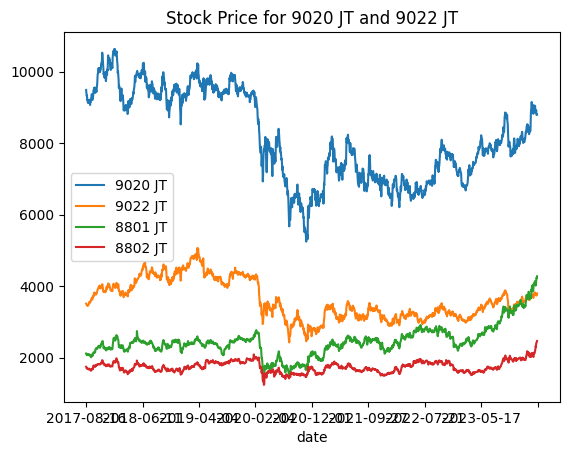

In [199]:
pairs_list = [['9020 JT', '9022 JT'], ['8801 JT', '8802 JT']]

# show the price of the selected pairs ['9020 JT', '9022 JT']
stock_price.loc['9020 JT'].plot()
stock_price.loc['9022 JT'].plot()
stock_price.loc['8801 JT'].plot()
stock_price.loc['8802 JT'].plot()
plt.title('Stock Price for 9020 JT and 9022 JT')
plt.legend()
plt.show()